Download the data

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2020-11-10 03:15:09--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.86.66, 13.32.86.52, 13.32.86.49, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.86.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  18.0MB/s    in 0.2s    

2020-11-10 03:15:09 (18.0 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.tx

In [2]:
%matplotlib inline


Classifying Names with a Character-Level RNN
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string
import math

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
train_data = {}
validation_data = {}
test_data = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.7*len(lines)))]
    validation_data[category] = lines[int(math.floor(0.7*len(lines)))+1:int(math.floor(0.85*len(lines)))]
    test_data[category] = lines[int(math.floor(0.85*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Irish.txt', 'data/names/Czech.txt', 'data/names/Portuguese.txt', 'data/names/German.txt', 'data/names/Vietnamese.txt', 'data/names/Polish.txt', 'data/names/Chinese.txt', 'data/names/French.txt', 'data/names/Russian.txt', 'data/names/Dutch.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/English.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Arabic.txt', 'data/names/Korean.txt', 'data/names/Scottish.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [ ]:
print(category_lines['Italian'][:5])

['Sgro', 'Elena', 'Cipriani', 'Antonino', 'Africano']


In [ ]:
n_categories

18

In [ ]:
n_letters

57

Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [4]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <http://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [5]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)      

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [6]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [7]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8598, -2.8551, -2.8458, -2.7548, -2.9545, -2.9514, -2.8459, -2.8956,
         -2.9559, -2.7910, -2.9541, -2.9007, -2.9300, -2.8767, -2.9005, -2.8915,
         -2.9261, -2.9676]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('German', 3)


In [9]:
all_categories

['Irish',
 'Czech',
 'Portuguese',
 'German',
 'Vietnamese',
 'Polish',
 'Chinese',
 'French',
 'Russian',
 'Dutch',
 'Spanish',
 'Greek',
 'English',
 'Italian',
 'Japanese',
 'Arabic',
 'Korean',
 'Scottish']

We will also want a quick way to get a training example (a name and its
language):




In [10]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Banos
category = Spanish / line = Aberquero
category = German / line = Paulis
category = Korean / line = Chang
category = French / line = Patenaude
category = Chinese / line = Zhen
category = French / line = Patenaude
category = Chinese / line = Chieu
category = Japanese / line = Fujikage
category = Vietnamese / line = Banh


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [11]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [12]:
optimizer = torch.optim.Adam(rnn.parameters())

def train(category_tensor, line_tensor):
  
    hidden = rnn.initHidden()

    # reset gradient
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer.step()

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [27]:
import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss = 0
all_train_losses = []
all_validation_losses = []
all_validation_losses2 = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

def eval_dataset(dataset):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate(line_tensor)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion
  
print('\nIter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    train_loss += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses.append(train_loss / plot_every)
        train_loss = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss, _ = eval_dataset(validation_data)

        # save model with best validation loss
        if len(all_validation_losses) == 0 or average_validation_loss < min(all_validation_losses):
            torch.save(rnn, 'char_rnn_classification_model.pt')
        all_validation_losses.append(average_validation_loss)



Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 20s) 	1.8249 		Cornett / German ✗ (French)
10000 	12% 	(0m 43s) 	1.5684 		Jirik / Czech ✓
15000 	18% 	(1m 7s) 	1.4326 		Vilaro / Italian ✗ (Spanish)
20000 	25% 	(1m 30s) 	1.4320 		Petit / French ✓
25000 	31% 	(1m 53s) 	1.3568 		Osaragi / Japanese ✓
30000 	37% 	(2m 17s) 	1.2407 		Kremlicka / Russian ✗ (Czech)
35000 	43% 	(2m 40s) 	1.3341 		Labelle / French ✓
40000 	50% 	(3m 4s) 	1.3241 		Hennessy / Scottish ✗ (English)
45000 	56% 	(3m 27s) 	1.2533 		Varano / Italian ✓
50000 	62% 	(3m 50s) 	1.2257 		Bohmer / German ✓
55000 	68% 	(4m 14s) 	1.1874 		Nujdin / Russian ✓
60000 	75% 	(4m 37s) 	1.1694 		Coiro / Italian ✓
65000 	81% 	(5m 1s) 	1.1421 		Courtemanche / Irish ✗ (French)
70000 	87% 	(5m 24s) 	1.1369 		Michalovicova / Greek ✗ (Czech)
75000 	93% 	(5m 48s) 	1.1953 		Schuyler / German ✗ (Dutch)
80000 	100% 	(6m 11s) 	1.1515 		Macdonald / Scottish ✓


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




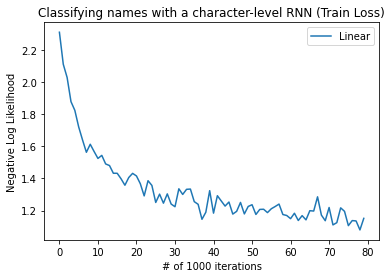

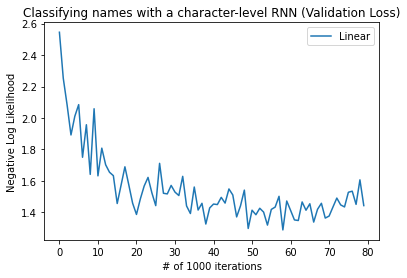

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_losses)
plt.title('Classifying names with a character-level RNN (Train Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(['Linear'], loc='upper right')


plt.figure()
plt.plot(all_validation_losses)
plt.title('Classifying names with a character-level RNN (Validation Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(['Linear'], loc='upper right')


Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




Average test loss: 1.2948517486358713


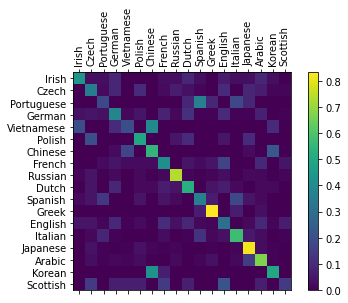

In [29]:
# evaluate on test set and display confusion matrix
rnn = torch.load('char_rnn_classification_model.pt')
average_test_loss, confusion = eval_dataset(test_data)
print('Average test loss: ' + str(average_test_loss))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [30]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Qi')
predict('Li')


> Dovesky
(-0.24) Russian
(-1.94) Czech
(-3.12) English

> Jackson
(-0.14) Scottish
(-2.72) Russian
(-3.05) English

> Satoshi
(-0.44) Arabic
(-1.55) Japanese
(-2.43) Polish

> Qi
(-0.70) Korean
(-1.51) Vietnamese
(-1.60) Chinese

> Li
(-0.11) Vietnamese
(-2.81) Korean
(-3.27) Chinese


The final versions of the scripts `in the Practical PyTorch
repo <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
split the above code into a few files:

-  ``data.py`` (loads files)
-  ``model.py`` (defines the RNN)
-  ``train.py`` (runs training)
-  ``predict.py`` (runs ``predict()`` with command line arguments)
-  ``server.py`` (serve prediction as a JSON API with bottle.py)

Run ``train.py`` to train and save the network.

Run ``predict.py`` with a name to view predictions:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON
output of predictions.




Exercises
=========

-  Try with a different dataset of line -> category, for example:

   -  Any word -> language
   -  First name -> gender
   -  Character name -> writer
   -  Page title -> blog or subreddit

-  Get better results with a bigger and/or better shaped network

   -  Add more linear layers
   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network




LSTM:

In [16]:
class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.LSTM=nn.LSTMCell(input_size,hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        hidden, cell = self.LSTM(input, (hidden,cell))
        combined = torch.cat((input, hidden), 1)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output,hidden,cell

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn_lstm = RNN_LSTM(n_letters, n_hidden, n_categories)  


In [21]:
input = lineToTensor('Annetta')
hidden = torch.zeros(1, n_hidden)
cell=torch.zeros(1, n_hidden)
output,hidden,cell= rnn_lstm(input[0], hidden,cell)
print(output)

tensor([[-2.5097, -2.9132, -4.0677, -3.3422, -1.9476, -3.1933, -4.4936, -3.7615,
         -2.8615, -3.6597, -4.0734, -2.8674, -3.9613, -2.7006, -2.0847, -3.6444,
         -1.7376, -3.7117]], grad_fn=<LogSoftmaxBackward>)


In [18]:
def train_LSTM(category_tensor, line_tensor):
    hidden = rnn_lstm.initHidden()
    cell= rnn_lstm.initHidden()
    # reset gradient
    rnn_lstm.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output,hidden,cell = rnn_lstm(line_tensor[i], hidden, cell)
    loss = criterion_lstm(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer_lstm.step()

    return output, loss.item()

In [19]:
import time
import math
criterion_lstm = nn.NLLLoss()
rnn_lstm = RNN_LSTM(n_letters, n_hidden, n_categories)  
optimizer_lstm = torch.optim.Adam(rnn_lstm.parameters())

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss_lstm = 0
all_train_losses_lstm = []
all_validation_losses_lstm = []
all_validation_losses2_lstm = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate_lstm(line_tensor):
    hidden = rnn_lstm.initHidden()
    cell= rnn_lstm.initHidden()
    for i in range(line_tensor.size()[0]):
        output,hidden,cell = rnn_lstm(line_tensor[i], hidden,cell)
    return output

def eval_dataset_lstm(dataset):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate_lstm(line_tensor)
            loss += criterion_lstm(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion
  
print('\nIter \tTrain% \tTime \t\tTrain_loss_lstm \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_LSTM(category_tensor, line_tensor)
    train_loss_lstm += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss_lstm / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_lstm.append(train_loss_lstm / plot_every)
        train_loss_lstm = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss_lstm, _ = eval_dataset_lstm(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_lstm) == 0 or average_validation_loss_lstm < min(all_validation_losses_lstm):
            torch.save(rnn_lstm, 'char_rnn_lstm_classification_model.pt')
        all_validation_losses_lstm.append(average_validation_loss_lstm)



Iter 	Train% 	Time 		Train_loss_lstm 	Example
5000 	6% 	(0m 45s) 	1.5696 		Abbadelli / Italian ✓
10000 	12% 	(1m 37s) 	1.2063 		Aiolfi / Italian ✓
15000 	18% 	(2m 29s) 	1.0547 		Ko / Korean ✓
20000 	25% 	(3m 22s) 	0.8488 		Samuel / French ✗ (Irish)
25000 	31% 	(4m 14s) 	0.7060 		Matocha / Czech ✓
30000 	37% 	(5m 6s) 	0.5294 		Royer / French ✓
35000 	43% 	(5m 58s) 	0.5352 		Chau / Vietnamese ✓
40000 	50% 	(6m 51s) 	0.4164 		Huynh / Vietnamese ✓
45000 	56% 	(7m 43s) 	0.4627 		Ooka / Japanese ✓
50000 	62% 	(8m 34s) 	0.3305 		Coma / Italian ✗ (Czech)
55000 	68% 	(9m 26s) 	0.2914 		Haik / Arabic ✓
60000 	75% 	(10m 17s) 	0.2937 		Vinh / Vietnamese ✓
65000 	81% 	(11m 9s) 	0.2919 		Gil / Korean ✓
70000 	87% 	(12m 1s) 	0.2836 		Baidjanoff / Russian ✓
75000 	93% 	(12m 53s) 	0.3426 		Kieu / Vietnamese ✓
80000 	100% 	(13m 46s) 	0.2572 		Maille / Irish ✓


GRU:

In [22]:
import torch.nn as nn
from torch.autograd import Variable

class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_GRU, self).__init__()

        self.hidden_size = hidden_size

        self.GRU=nn.GRUCell(input_size,hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = self.GRU(input, hidden)
        combined = torch.cat((input, hidden), 1)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output,hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn_gru = RNN_GRU(n_letters, n_hidden, n_categories)  

In [23]:
input = lineToTensor('Annetta')
hidden = torch.zeros(1, n_hidden)
output,hidden= rnn_gru(input[0], hidden)
print(output)

tensor([[-2.9508, -2.9775, -2.9361, -2.8884, -2.8290, -2.7962, -2.8107, -2.9000,
         -2.9911, -2.9269, -3.0018, -2.9378, -2.8743, -2.7615, -2.7985, -2.8826,
         -2.8874, -2.9185]], grad_fn=<LogSoftmaxBackward>)


In [24]:
criterion_gru = nn.NLLLoss()
optimizer_gru = torch.optim.Adam(rnn_gru.parameters())

def train_GRU(category_tensor, line_tensor):
    hidden = rnn_gru.initHidden()
    # reset gradient
    rnn_gru.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output,hidden = rnn_gru(line_tensor[i], hidden)
    loss = criterion_gru(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer_gru.step()

    return output, loss.item()

In [25]:
import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss_gru = 0
all_train_losses_gru = []
all_validation_losses_gru = []
all_validation_losses2_gru = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate_gru(line_tensor):
    hidden = rnn_gru.initHidden()
    for i in range(line_tensor.size()[0]):
        output,hidden = rnn_gru(line_tensor[i], hidden)
    return output

def eval_dataset_gru(dataset):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate_gru(line_tensor)
            loss += criterion_gru(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion
  
print('\nIter \tTrain% \tTime \t\tTrain_loss_gru \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_GRU(category_tensor, line_tensor)
    train_loss_gru += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss_gru / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_gru.append(train_loss_gru / plot_every)
        train_loss_gru = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss_gru, _ = eval_dataset_gru(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_gru) == 0 or average_validation_loss_gru < min(all_validation_losses_gru):
            torch.save(rnn_gru, 'char_rnn_gru_classification_model.pt')
        all_validation_losses_gru.append(average_validation_loss_gru)


Iter 	Train% 	Time 		Train_loss_gru 	Example
5000 	6% 	(0m 45s) 	1.4706 		Srour / Arabic ✓
10000 	12% 	(1m 35s) 	1.1391 		Stolarz / Polish ✓
15000 	18% 	(2m 26s) 	0.8935 		Mersinias / Greek ✓
20000 	25% 	(3m 17s) 	0.7689 		Vandale / French ✗ (Dutch)
25000 	31% 	(4m 10s) 	0.5994 		Busch / Scottish ✗ (German)
30000 	37% 	(5m 0s) 	0.5376 		Huajev / Russian ✓
35000 	43% 	(5m 51s) 	0.4461 		Rojo / Spanish ✓
40000 	50% 	(6m 41s) 	0.3995 		Acconci / Italian ✓
45000 	56% 	(7m 32s) 	0.3971 		Ying / Chinese ✓
50000 	62% 	(8m 23s) 	0.2969 		Romijnsen / Dutch ✓
55000 	68% 	(9m 13s) 	0.3564 		Gibson / Scottish ✓
60000 	75% 	(10m 4s) 	0.2982 		Pinter / English ✗ (Czech)
65000 	81% 	(10m 55s) 	0.2931 		Abana / Spanish ✓
70000 	87% 	(11m 45s) 	0.2958 		Kyubei / Japanese ✓
75000 	93% 	(12m 36s) 	0.2794 		Sanchez / Spanish ✓
80000 	100% 	(13m 26s) 	0.2640 		Gim / Chinese ✓


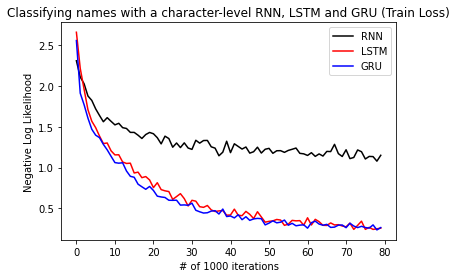

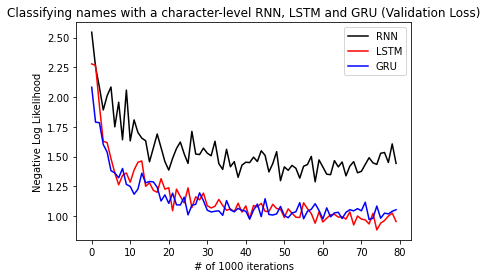

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_losses,"k")
plt.plot(all_train_losses_lstm,"r")
plt.plot(all_train_losses_gru,"b")
plt.title('Classifying names with a character-level RNN, LSTM and GRU (Train Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(['RNN',"LSTM","GRU"], loc='upper right')


plt.figure()
plt.plot(all_validation_losses,"k")
plt.plot(all_validation_losses_lstm,"r")
plt.plot(all_validation_losses_gru,"b")
plt.title('Classifying names with a character-level RNN, LSTM and GRU (Validation Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(['RNN',"LSTM","GRU"], loc='upper right')


Confusion matrix and test loss for RNN:

Average test loss: 1.2948517486358713


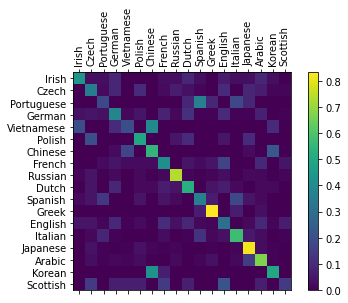

In [32]:
# evaluate on test set and display confusion matrix
rnn = torch.load('char_rnn_classification_model.pt')
average_test_loss, confusion = eval_dataset(test_data)
print('Average test loss: ' + str(average_test_loss))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Confusion matrix and test loss for LSTM:

Average test loss: 0.9065782597207181


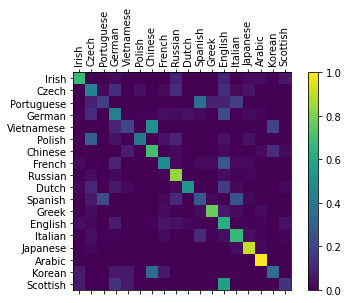

In [33]:
# evaluate on test set and display confusion matrix
rnn_lstm = torch.load('char_rnn_lstm_classification_model.pt')
average_test_loss_lstm, confusion_lstm = eval_dataset_lstm(test_data)
print('Average test loss: ' + str(average_test_loss_lstm))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_lstm.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Confusion matrix and test loss for GRU:

Average test loss: 0.9426787750437354


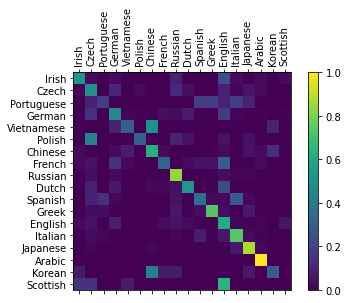

In [34]:
# evaluate on test set and display confusion matrix
rnn_gru = torch.load('char_rnn_gru_classification_model.pt')
average_test_loss_gru, confusion_gru = eval_dataset_gru(test_data)
print('Average test loss: ' + str(average_test_loss_gru))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_gru.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Based on test loss, validation loss and training loss, we have loss LSTM<GRU<RNN. Performance in terms of cell is LSTM cell is better than GRU cell which is better than linear cell. The reason why we prefer LSTM and GRU is sometimes we try to predict a word in a book, we are given a whole book or large amount of sentences to learn and we attempt to predict next work based on some previous words, in this case long range dependency would be a concern- that we hope longer sentences, more historic information can be stored to act as a reference book, so it makes predicting next word much easier simply because it gives relavant information previously to infer next word. In our example, language to predict based on a name, it would be better to remember as many name examples across different languages as possible. For linear hidden units it just give prediction based on last input. By imposing LSTM cell as hidden unit, we adding a lot of parameters which responsible for 3 different gates: input gate, forget gate and output gate to decide whether we need absorbing new input, forget about everything we learn, output. More parameters means more time and better optimizer should be used and more parameter should be tuned.  Another point is gradient vanishing or exposion, for RNN we fit many reccurent cells (deep neural network) since information has to pass through one recurrent cell to the next, so gradient faces problem of close to 0 or super large. Using LSTM or GRU can help us mitigate this problem simply because it give option to close cell passing, input passing and outputing. GRU works similar to LSTM except it only offers two kind of gates, so its performance is in between of RNN and LSTM. On thing to notice is GRU require less time to converge than LSTM since it has fewer parameters.    